IML 2025 Assignment 1

Jiwoo Hong MTNR1
Yeongjae Park m12446610
Yoonhyeok Lee MTNR3

# Definition of input files

In [2]:
#These filename need to be defined:

#  current dataset directory : data/alldigits.csv
#  amount of data: 6000
#  structure of each datum: [28x28 pixels with value 0x00 ~ 0xFF, 1 label with value 0 ~ 9]

datafile_name = 'data/alldigits.csv'

# Your sections ...

# Calc1: Read data

In [3]:
import numpy as np


all_digits = np.loadtxt(datafile_name, delimiter=',', skiprows=1)



# Preprocessing: Data split

In [ ]:
import math

#  variable parameters - can be adjusted
RATIO_TRAIN_DATA = 0.8
RATIO_VALIDATE_DATA = 0.1
RATIO_TEST_DATA = 0.1

#  constants - must be fixed
DATASET_SIZE = 6000  #  precomputated value


if RATIO_TRAIN_DATA + RATIO_VALIDATE_DATA + RATIO_TEST_DATA != 1.0:
    raise AssertionError("Sum of ratios must be 1.0")


all_digits_by_labels = [[] for _ in range(10)]

for dg in all_digits:
    dg = [dg[:-1], int(dg[-1])]
    all_digits_by_labels[dg[1]].append(dg)
for one_labeled_digits in all_digits_by_labels:
    np.random.shuffle(one_labeled_digits)

digits_train, digits_validate, digits_test = [], [], []


for i in range(10):
    target_labeled_set = all_digits_by_labels[i]
    idx_train_end = math.floor(len(target_labeled_set) * RATIO_TRAIN_DATA)
    idx_validate_end = idx_train_end + math.floor(len(target_labeled_set) * RATIO_VALIDATE_DATA)
    idx_test_end = idx_validate_end + math.floor(len(target_labeled_set) * RATIO_TEST_DATA)

    digits_train += target_labeled_set[:idx_train_end]
    digits_validate += target_labeled_set[idx_train_end:idx_validate_end]
    digits_test += target_labeled_set[idx_validate_end:idx_test_end]
    digits_train += target_labeled_set[idx_test_end:]  #  TODO: how can we distribute the remained data equally?

for digits in [digits_train, digits_validate, digits_test]:
    np.random.shuffle(digits)


digits_train_x, digits_train_y = np.array([d[0] for d in digits_train]), np.array([d[1] for d in digits_train])
digits_validate_x, digits_validate_y = np.array([d[0] for d in digits_validate]), np.array([d[1] for d in digits_validate])
digits_test_x, digits_test_y = np.array([d[0] for d in digits_test]), np.array([d[1] for d in digits_test])


(4810, 784) (4810,)


# Explore

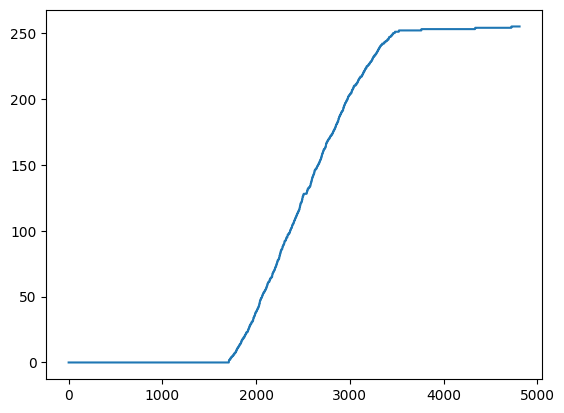

In [7]:
import matplotlib.pyplot as plt

px = digits_train_x[:,400]
px.sort()
plt.plot(px)

# Calc2: Naive Bayes

In [4]:
from sklearn.naive_bayes import GaussianNB

X = digits_train[:, :-1]
y = digits_train[:, -1]

gnb = GaussianNB().fit(X,y)

KeyboardInterrupt: 

# ...

# Final classifiers

In [11]:
#This classifier needs to be defined:
digits_SVM = gnb